problem to solve:
a) store houses data from different pages ---> understand where we'll store tha pages
d) jaccard similarity
e) draw wordcloud
f) comments

In [59]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import requests
from requests import get
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from math import log
from math import sqrt
import re
from collections import Counter
from time import sleep
from random import randint
from warnings import warn
import numpy as np
from IPython.core.display import clear_output
from time import time
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_similarity_score
import matplotlib.pyplot as plt

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
pages = [str(i) for i in range(1,445)]

In [5]:
pages = [str(i) for i in range(1,3)]

In [38]:
# Lists to store the scraped data int
prices = []
locals_ = []
surfaces = []
bathrooms = []
floors = []
descriptions = []

In [39]:
# Preparing the monitoring of the loop
start_time = time()
requests = 0

for page in pages:
    url = ('https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=' +page)
    response = get(url)
    # Pause the loop
    sleep(randint(8,15))
    # Monitor the requests
    requests += 1
    elapsed_time = time() - start_time
    print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)
    # Throw a warning for non-200 status codes
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
    # Break the loop if the number of requests is greater than expected
    if requests > 10000:
        warn('Number of requests was greater than expected.')  
        break
    # Parse the content of the request with BeautifulSoup
    page_html = BeautifulSoup(response.text, 'html.parser')

    # Select all the 50 movie containers from a single page
    house_containers = page_html.find_all('div', class_ = 'listing-item_body--content')
    for house in house_containers:
        house.find('li', class_ = '"lif__item lif__pricing')
        locals_surface_bathrooms = house.findAll('span', class_="text-bold")
        filtering_floor= house.findAll('abbr', class_="text-bold im-abbr") 
    # If the house has all info that need us (price, locals, surface, bathroom and floor) then extract:
        if len(locals_surface_bathrooms) == 3 :
            if len(filtering_floor) == 1: 
                floor = house.find('abbr', class_="text-bold im-abbr").text.strip()
                if  floor != 'A' and floor != 'S' and floor != 'T':  #don't take houses with A,S,T value for the floor

        # The price
                          price = house.find('li', class_="lif__item lif__pricing").text.strip()
                          #if condition needs us to know if price has got also old price (in this case price has % character)
                          if '%' in price : 
                              price = house.find('div').text.strip()
                          price = re.sub('[€] ', '', price)
                          price = re.sub('[.]', '', price)
                          price = int(price)
                          prices.append(price)

        #the number of locals, surface (m^2), and number of bathrooms
                          local_ = locals_surface_bathrooms[0].text.strip()
                          if '+' in local_:
                              local_ = re.sub('[+]', '', local_)
                          locals_.append(int(local_))
                          surface = locals_surface_bathrooms[1].text.strip()
                          surfaces.append(int(surface))
                          bathroom = locals_surface_bathrooms[2].text.strip()
                          if '+' in bathroom:
                              bathroom = re.sub('[+]', '', bathroom)
                          bathrooms.append(int(bathroom))
        
        #the floor
                          floors.append(int(floor))

        # the description
                          description = house.find('p', class_="descrizione__truncate").text.strip()
                          descriptions.append(description)

Request:2; Frequency: 0.08492658523552025 requests/s


In [40]:
test_df = pd.DataFrame({'price': prices,
                       'locals': locals_,
                       'surface': surfaces,
                       'bathroom': bathrooms,
                       'floor': floors})

In [41]:
test_df

,price,locals,surface,bathroom,floor
0,225000,2,50,1,1
1,300000,2,46,1,4
2,669000,5,86,2,4
3,500000,3,89,2,3
4,425000,3,72,2,4
5,400000,3,60,1,3
6,574000,4,89,2,5
7,657000,5,87,2,5
8,257000,3,61,1,1
9,325000,2,60,1,3


Let's to cleaning houses description

In [42]:
def clening_description(description):  # use all the techniques to remove unwanted items from words
    
    tokenizer = RegexpTokenizer(r'\w+')
    ps = PorterStemmer()
    # Remove "\\n" and replace with a space
    description = description.replace("\\n", " ")
    # Convert everything to lowercase
    description = description.lower()
    # Removing punctuation
    description = tokenizer.tokenize(description)
    # Stemming
    description = [ps.stem(word) for word in description]
    # Removing stopwords
    description = [word for word in description if word not in stopwords.words('italian')]
    # No integers
    description = [x for x in description if not (x.isdigit() or x[0].isdigit())]
    return description

In [43]:
cleaned_descriptions = []
for description in descriptions:
    cleaned_description = clening_description(description)
    cleaned_descriptions.append(cleaned_description)
    
    

In [44]:
corpus = [y for x in cleaned_descriptions for y in x]

#all words present in all descriptions

In [45]:
count_corpus = Counter(corpus)
count_corpus= dict(count_corpus.most_common())

final_dict = {str(i+1):x for i,x in enumerate(count_corpus)}
final_dict_inv = {str(x):(i+1) for i,x in enumerate(count_corpus)}

In [46]:
indx = {}
for n,document in enumerate(cleaned_descriptions):
    new_document = []
    for word in document:
        new_document.append(final_dict_inv[str(word)])
    indx[str(n+1)] = new_document 
    
inv_indx = {str(i):[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i in range(len(indx)):
        if int(word) in indx[str(i+1)]:
            inv_indx[word].append(i+1)

In [47]:
houses_count= len(test_df)

In [48]:
inv_indx_cosine = {i:[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i,l in enumerate(list(indx.values())):
        if int(word) in l:
            tf = l.count(int(word))/len(l)
            id_f = log(houses_count/len(inv_indx[word]))
            inv_indx_cosine[word].append((i+1,tf*id_f))

Let's to deal with our inv_indx_cosine to build tf-idf matrix 

In [49]:
converting = [(k, *t) for k, v in inv_indx_cosine.items() for t in v ]


In [50]:
test = pd.DataFrame(converting, columns=['Word', 'Document', 'Tf-Idf'])

In [51]:
matrix_tfidf = test.pivot_table(index = 'Document', columns = 'Word', values='Tf-Idf', fill_value = 0)

In [52]:
matrix_tfidf.head()

Word,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
Document,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068511,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.007012,0.025219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.007012,0.025219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.070526,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.006623,0.023818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.066608,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.007225,0.025983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


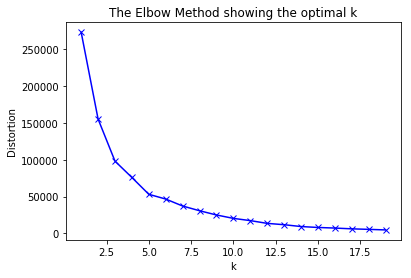

In [60]:
# k means determine k for first matrix
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(test_df)
    kmeanModel.fit(test_df)
    distortions.append(sum(np.min(cdist(test_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / test_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow matrix shows that the better number of cluster for the first matrix is 5 (the point where the plot starts the "elbow")

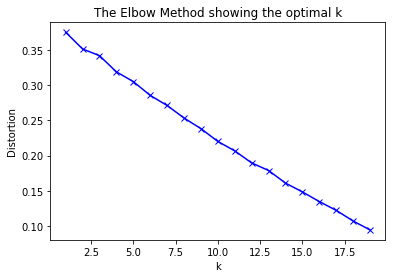

In [62]:
# k means determine k for second matrix
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(matrix_tfidf)
    kmeanModel.fit(matrix_tfidf)
    distortions.append(sum(np.min(cdist(matrix_tfidf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / test_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow matrix shows that there'is a visible better number of cluster for the second matrix. So we choise to deal with 20 clusters

In [129]:
# kmeans++ clustering for first matrix with k = 5 (choosen with elbow method)
cluster = sklearn.cluster.KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
cluster.fit(test_df)
centroid = cluster.cluster_centers_
labels = cluster.labels_

In [74]:
cluster

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [75]:
centroid


array([[4.75500000e+05, 3.80000000e+00, 1.01700000e+02, 1.80000000e+00,
        3.60000000e+00],
       [1.68000000e+06, 5.00000000e+00, 2.10000000e+02, 2.00000000e+00,
        5.00000000e+00],
       [1.09200000e+06, 5.00000000e+00, 1.96000000e+02, 2.20000000e+00,
        1.80000000e+00],
       [7.07666667e+05, 4.66666667e+00, 1.15666667e+02, 1.66666667e+00,
        3.00000000e+00],
       [2.53363636e+05, 2.63636364e+00, 7.46363636e+01, 1.18181818e+00,
        2.45454545e+00]])

In [76]:
labels

array([4, 4, 3, 0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 3, 0, 4, 0,
       2, 1, 2, 4, 2, 3, 3, 2, 2, 3, 0])

In [77]:
# kmeans++ clustering for second matrix with k = 20 (choose with elbow method)
cluster2 = sklearn.cluster.KMeans(n_clusters=20, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
cluster2.fit(matrix_tfidf)
centroid2 = cluster2.cluster_centers_
labels2 = cluster2.labels_

In [122]:
cluster2

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [79]:
centroid2

array([[ 7.56056665e-03,  2.27374491e-02,  1.73472348e-18, ...,
         1.73472348e-18, -8.67361738e-19,  6.22829941e-03],
       [ 7.01208892e-03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.26634931e-02,  0.00000000e+00,  0.00000000e+00],
       [ 7.22457647e-03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  7.26634931e-02,  7.26634931e-02],
       [ 5.67967271e-03,  1.04567101e-02,  0.00000000e+00, ...,
         0.00000000e+00,  2.78825032e-02,  0.00000000e+00]])

In [120]:
labels

array([4, 4, 3, 0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 3, 0, 4, 0,
       2, 1, 2, 4, 2, 3, 3, 2, 2, 3, 0])

In [124]:
labels2

array([ 7,  0,  0,  0,  0,  0,  0,  0,  8,  0,  7,  7,  0, 14,  3, 15,  4,
       18,  2,  5, 13, 19, 17, 11,  0,  0, 16,  9, 10,  6, 19, 12,  1])

Let's add label column to both matrixs to know the number of cluster for each announcement and for each document

In [137]:
labels_se = pd.Series(labels)
test_df['labels'] = labels_se.values
test_df.head()

,price,locals,surface,bathroom,floor,labels
0,225000,2,50,1,1,2
1,300000,2,46,1,4,2
2,669000,5,86,2,4,4
3,500000,3,89,2,3,0
4,425000,3,72,2,4,0


In [136]:
labels2_se = pd.Series(labels2)
matrix_tfidf['labels2'] = labels2_se.values
matrix_tfidf.head()

Word,1,10,100,101,102,103,104,105,106,107,...,91,92,93,94,95,96,97,98,99,labels2
Document,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,0.007012,0.025219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.007012,0.025219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.070526,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.006623,0.023818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.066608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.007225,0.025983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Ora bisogna calcolare il jaccard similarity tra coppie di cluster. La colonna label e labels2 servono a specificare, per ogni riga,
a quale cluster appartiene (per la prima matrice da 0 a 4 (i cluster sono 5), seconda i cluster vanno da 0 a 19 (i cluster sono 20)).
La jaccard va calcolata tra coppie di cluster appartenenti alle due matrici: quindi tra cluster 0 della matrice 1 e cluster 0 della matrice 2, ecc ecc.

In [123]:
a = []
jaccard_similarity_vector = []
for x in :
    for j in :
        a = jaccard_similarity_score(x,j)
        jaccard_similarity_vector.append(a)

TypeError: Singleton array 4 cannot be considered a valid collection.

Una volta calcolata la jaccard va fatto il word cloud, inserito qualche commento e il nostro lavoro è terminato!